# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [ ]:
  import importlib
  import data
  importlib.reload(data)

  from data import * #create_dir, load_data, augment_data

  import os
  os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
  import numpy as np
  import cv2
  from glob import glob
  from sklearn.utils import shuffle
  import tensorflow as tf
  from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, AUC

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Data Reading

In [ ]:
# Seeding
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load data
data_path = "/content/drive/MyDrive/Datasets/DRIVE_Shared/DRIVE"
(train_x, train_y), (test_x, test_y) = load_data(data_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test:  {len(test_x)} - {len(test_y)}")

Train: 20 - 20
Test:  20 - 20


In [ ]:
# Create directories
create_dir("new_data/train/image")
create_dir("new_data/train/mask")
create_dir("new_data/test/image")
create_dir("new_data/test/mask")

# Augmentation

In [ ]:
augment_data(train_x, train_y, "new_data/train/", augment=True)
augment_data(test_x,  test_y,  "new_data/test/",  augment=False)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:45<00:00,  2.26s/it]


# SAM

In [ ]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# !pip install opencv-python matplotlib

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-u1y504ip
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-u1y504ip
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything

Cloning into 'segment-anything'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 304 (delta 2), reused 1 (delta 1), pack-reused 299 (from 2)
Receiving objects: 100% (304/304), 18.31 MiB | 37.58 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [ ]:
!cd segment-anything
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-05-27 11:27:58--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.118, 3.171.22.68, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‚Äòsam_vit_h_4b8939.pth‚Äô

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   336MB/s    in 7.4s    

2025-05-27 11:28:05 (329 MB/s) - ‚Äòsam_vit_h_4b8939.pth‚Äô saved [2564550879/2564550879]



In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2025-05-27 11:28:06--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.118, 3.171.22.68, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‚Äòsam_vit_b_01ec64.pth‚Äô

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   294MB/s    in 1.2s    

2025-05-27 11:28:07 (294 MB/s) - ‚Äòsam_vit_b_01ec64.pth‚Äô saved [375042383/375042383]



In [ ]:
# from segment_anything import sam_model_registry, SamPredictor
# import torch

# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"

# device = "cuda" if torch.cuda.is_available() else "cpu"

# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

# predictor = SamPredictor(sam)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# # Load and prepare image
# image_path = test_x[0]  # Your DRIVE image
# image_bgr = cv2.imread(image_path)
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# # Load SAM model and move to GPU
# sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
# sam.to("cuda")

# # Automatic mask generator
# mask_generator = SamAutomaticMaskGenerator(sam)

# # Generate masks (this is the zero-shot part!)
# masks = mask_generator.generate(image_rgb)

# # Show first few masks
# for i in range(min(3, len(masks))):
#     plt.figure(figsize=(6, 6))
#     plt.imshow(masks[i]["segmentation"], cmap='gray')
#     plt.title(f"Mask {i}")
#     plt.axis('off')
#     plt.show()

# SAM Adapter

In [ ]:
!git clone https://github.com/tianrun-chen/SAM-Adapter-PyTorch.git
%cd SAM-Adapter-PyTorch

fatal: destination path 'SAM-Adapter-PyTorch' already exists and is not an empty directory.
/content/SAM-Adapter-PyTorch


In [ ]:
# load/
# ‚îî‚îÄ‚îÄ DRIVE/
#     ‚îú‚îÄ‚îÄ Images/
#     ‚îÇ   ‚îî‚îÄ‚îÄ Train/
#     ‚îÇ       ‚îú‚îÄ‚îÄ 01.jpg
#     ‚îÇ       ‚îú‚îÄ‚îÄ 02.jpg
#     ‚îÇ       ‚îî‚îÄ‚îÄ ...
#     ‚îî‚îÄ‚îÄ Train_gt/
#         ‚îú‚îÄ‚îÄ 01.png
#         ‚îú‚îÄ‚îÄ 02.png
#         ‚îî‚îÄ‚îÄ ...

In [ ]:
import shutil

src = "/content/drive/MyDrive/Datasets/DRIVE_Shared/DRIVE"
dst = "/content/DRIVE"

shutil.copytree(src, dst)

'/content/DRIVE'

In [ ]:
!pwd

/content/SAM-Adapter-PyTorch


In [ ]:
import os
from PIL import Image
from glob import glob

# Source dirs (original DRIVE)
src_train_img = "/content/DRIVE/training/images"
src_train_mask = "/content/DRIVE/training/mask"
src_test_img = "/content/DRIVE/test/images"
src_test_mask = "/content/DRIVE/test/mask"

# Destination dirs (SAM format)
dst_train_img = "/content/SAM-Adapter-PyTorch/load/DRIVE/Images/Train"
dst_test_img = "/content/SAM-Adapter-PyTorch/load/DRIVE/Images/Test"
dst_train_mask = "/content/SAM-Adapter-PyTorch/load/DRIVE/Train_gt"
dst_test_mask = "/content/SAM-Adapter-PyTorch/load/DRIVE/Test_gt"

# Make dirs
for d in [dst_train_img, dst_test_img, dst_train_mask, dst_test_mask]:
    os.makedirs(d, exist_ok=True)

# Save training images (20)
train_imgs = sorted(glob(os.path.join(src_train_img, "*.tif")))
train_masks = sorted(glob(os.path.join(src_train_mask, "*.gif")))

for img_path, mask_path in zip(train_imgs, train_masks):
    name = os.path.splitext(os.path.basename(img_path))[0].split('_')[0]
    img = Image.open(img_path).convert("RGB").resize((1024, 1024))
    mask = Image.open(mask_path).convert("L").resize((1024, 1024))
    img.save(os.path.join(dst_train_img, f"{name}.jpg"))
    mask.save(os.path.join(dst_train_mask, f"{name}.png"))

# Save test images (20)
test_imgs = sorted(glob(os.path.join(src_test_img, "*.tif")))
test_masks = sorted(glob(os.path.join(src_test_mask, "*.gif")))

for img_path, mask_path in zip(test_imgs, test_masks):
    name = os.path.splitext(os.path.basename(img_path))[0].split('_')[0]
    img = Image.open(img_path).convert("RGB").resize((1024, 1024))
    mask = Image.open(mask_path).convert("L").resize((1024, 1024))
    img.save(os.path.join(dst_test_img, f"{name}.jpg"))
    mask.save(os.path.join(dst_test_mask, f"{name}.png"))

In [ ]:
!mkdir pretrained

In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124


In [ ]:
!pip install openmim

In [ ]:
!mim install mmengine

Looking in links: https://download.openmmlab.com/mmcv/dist/cu124/torch2.6.0/index.html
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached yapf-0.43.0-py3-none-any.whl.metadata (46 kB)
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 452.7/452.7 kB 8.6 MB/s eta 0:00:00
Using cached addict-2.4.0-py3-none-any.whl (3.8 kB)
Using cached yapf-0.43.0-py3-none-any.whl (256 kB)


In [ ]:
!mim install "mmcv==1.7.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cu124/torch2.6.0/index.html
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 593.6/593.6 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mmcv: filename=mmcv-1.7.0-py2.py3-none-any.whl size=914092 sha256=acf8253163f01e333f951b8a4e13682be102e64ff26930f906ef45ac5a7fa73c
  Stored in directory: /root/.cache/pip/wheels/66/d0/a2/34a56873c2e34fcd543be19c8e09c93741a7ee0c13b5dfc983
Successfully built mmcv
  Attempting uninstall: mmcv
    Found existing installation: mmcv 1.7.1
    Uninstalling mmcv-1.7.1:
      Successfully uninstalled mmcv-1.7.1


In [ ]:
!pip install -r requirements.txt

In [ ]:
!python train.py --config configs/drive.yaml

/usr/local/lib/python3.11/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
config loaded.
train dataset: size=20
  inp: shape=(3, 1024, 1024)
  gt: shape=(1, 1024, 1024)
val dataset: size=20
  inp: shape=(3, 1024, 1024)
  gt: shape=(1, 1024, 1024)
model: #params=93.9M
‚úÖ Filtered SAM checkpoint loaded.
‚ö†Ô∏è Missing keys: 56
model_grad_params:4121908 
model_total_params:93876788
‚úÖ Finished epoch 21/40 ‚Äî train_loss_G: 1.8523
‚úÖ Finished epoch 22/40 ‚Äî train_loss_G: 1.2400
‚úÖ Finished epoch 23/40 ‚Äî train_loss_G: 1.2257
‚úÖ Finished epoch 24/40 ‚Äî train_loss_G: 1.2007
‚úÖ Finished epoch 25/40 ‚Äî train_loss_G: 1.1542
‚úÖ Finished epoch

In [ ]:
# /usr/local/lib/python3.11/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
#   warnings.warn(
# config loaded.
# train dataset: size=20
#   inp: shape=(3, 1024, 1024)
#   gt: shape=(1, 1024, 1024)
# val dataset: size=20
#   inp: shape=(3, 1024, 1024)
#   gt: shape=(1, 1024, 1024)
# model: #params=93.9M
# ‚úÖ Filtered SAM checkpoint loaded.
# ‚ö†Ô∏è Missing keys: 56
# model_grad_params:4121908
# model_total_params:93876788
# ‚úÖ Finished epoch 1/20 ‚Äî train_loss_G: 1.8652
# ‚úÖ Finished epoch 2/20 ‚Äî train_loss_G: 1.2471
# ‚úÖ Finished epoch 3/20 ‚Äî train_loss_G: 1.2444
# ‚úÖ Finished epoch 4/20 ‚Äî train_loss_G: 1.2425
# ‚úÖ Finished epoch 5/20 ‚Äî train_loss_G: 1.2383
# ‚úÖ Finished epoch 6/20 ‚Äî train_loss_G: 1.2333
# ‚úÖ Finished epoch 7/20 ‚Äî train_loss_G: 1.2203
# ‚úÖ Finished epoch 8/20 ‚Äî train_loss_G: 1.2137
# ‚úÖ Finished epoch 9/20 ‚Äî train_loss_G: 1.2013
# ‚úÖ Finished epoch 10/20 ‚Äî train_loss_G: 1.1744
# ‚úÖ Finished epoch 11/20 ‚Äî train_loss_G: 1.0605
# ‚úÖ Finished epoch 12/20 ‚Äî train_loss_G: 0.9358
# ‚úÖ Finished epoch 13/20 ‚Äî train_loss_G: 0.7919
# ‚úÖ Finished epoch 14/20 ‚Äî train_loss_G: 0.7051
# ‚úÖ Finished epoch 15/20 ‚Äî train_loss_G: 0.6665
# ‚úÖ Finished epoch 16/20 ‚Äî train_loss_G: 0.6399
# ‚úÖ Finished epoch 17/20 ‚Äî train_loss_G: 0.6303
# ‚úÖ Finished epoch 18/20 ‚Äî train_loss_G: 0.6276
# ‚úÖ Finished epoch 19/20 ‚Äî train_loss_G: 0.6336
# ‚úÖ Finished epoch 20/20 ‚Äî train_loss_G: 0.6159

In [ ]:
from models import make as make_model
import torch

# Load config
import yaml
with open("configs/drive.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Rebuild model
model = make_model(config["model"]).cuda()

# Load weights
ckpt_path = "save/_drive/model_epoch_last.pth"
model.load_state_dict(torch.load(ckpt_path))
model.eval()

SAM(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [ ]:
from PIL import Image
import torchvision.transforms as T

img_path = "load/DRIVE/Images/Test/01.jpg"  # any test image
image = Image.open(img_path).convert("RGB").resize((1024, 1024))

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
input_tensor = transform(image).unsqueeze(0).cuda()  # [1, 3, 1024, 1024]

In [ ]:
with torch.no_grad():
    pred = model.infer(input_tensor)  # [1, 1, 1024, 1024]
    pred_mask = torch.sigmoid(pred).squeeze().cpu().numpy()

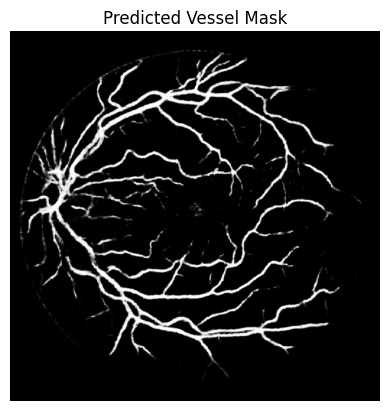

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Vessel Mask")
plt.axis("off")
plt.show()

# Medical SAM Adapter?

https://huggingface.co/KidsWithTokens/Medical-Adapter-Zoo

In [ ]:
!git clone https://github.com/SuperMedIntel/Medical-SAM-Adapter.git
%cd Medical-SAM-Adapter

fatal: destination path 'Medical-SAM-Adapter' already exists and is not an empty directory.
/content/Medical-SAM-Adapter


In [ ]:
# !pip install konda
# import konda
# konda.install()

Installing Miniconda to /usr/local...
‚úÖ Miniconda installed successfully!
Run '!conda --version' to check if conda is working.

üìã Usage examples:
  konda create -n my_env python=3.11 -y
  konda activate my_env


In [ ]:
# !konda create -n my_env python=3.8 -y
# !konda activate my_env

Channels:
 - defaults
Platform: linux-64
Solving environment: | done

## Package Plan ##

  environment location: /usr/local/envs/my_env

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pip-24.2                   |   py38h06a4308_0         2.2 MB
    python-3.8.20              |       he870216_0        23.8 MB
    setuptools-75.1.0          |   py38h06a4308_0         1.7 MB
    wheel-0.44.0               |   py38h06a4308_0         108 KB
    ------------------------------------------------------------
                                           Total:        27.8 MB

The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main 
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-5.1-1_gnu 
  ca-certificates    pkgs/main/linux-64::ca-certificates-2025.2.25-h06a4308_0 
  ld_impl_linux-64   pkg

In [ ]:
# !konda env update -n my_env -f environment.yml

/usr/local/lib/python3.13/argparse.py:1255: FutureWarning: `remote_definition` is deprecated and will be removed in 25.9. Use `conda env create --file=URL` instead.
  subnamespace, arg_strings = subparser.parse_known_args(arg_strings, None)
Channels:
 - pytorch
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: \ | / - \ done


Preparing transaction: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done
Verifying transaction: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
Executing transaction: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ |

In [ ]:
# !mkdir -p checkpoint/sam

In [ ]:
# !mkdir -p pretrained

In [ ]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

‚ú®üç∞‚ú® Everything looks OK!


In [ ]:
# !conda --version

conda 24.11.2


In [ ]:
# !conda env update -n base -f environment.yml

Channels:
 - pytorch
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: - \ failed

SpecsConfigurationConflictError: Requested specs conflict with configured specs.
  requested specs: 
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==5.1=1_gnu
    - abseil-cpp==20211102.0=hd4dd3e8_0
    - absl-py==1.3.0=py310h06a4308_0
    - aiohttp==3.8.3=py310h5eee18b_0
    - async-timeout==4.0.2=py310h06a4308_0
    - attrs==22.1.0=py310h06a4308_0
    - blas==1.0=mkl
    - blosc==1.21.3=h6a678d5_0
    - bottleneck==1.3.5=py310ha9d4c09_0
    - brotli==1.0.9=h5eee18b_7
    - brotli-bin==1.0.9=h5eee18b_7
    - brotlipy==0.7.0=py310h7f8727e_1002
    - brunsli==0.1=h2531618_0
    - bzip2==1.0.8=h7b6447c_0
    - c-ares==1.19.0=h5eee18b_0
    - ca-certificates==2023.11.17=hbcca054_0
    - cffi==1.15.1=py310h5eee18b_3
    - cfitsio==3.470=h5893167_7
    - charls==2.2.0=h2531618_0
    - cloudpickle==2.2.1=py310h06a4308_0
    - comm==0.1.4=pyhd8ed1ab_0
    - contourpy==1.0.5=py310hdb19cb5

In [ ]:
# !konda list -n my_env

# packages in environment at /usr/local/envs/my_env:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
abseil-cpp                20211102.0           hd4dd3e8_0  
absl-py                   1.3.0           py310h06a4308_0  
aiohttp                   3.8.3           py310h5eee18b_0  
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
asttokens                 3.0.0              pyhd8ed1ab_1    conda-forge
async-timeout             4.0.2           py310h06a4308_0  
attrs                     22.1.0          py310h06a4308_0  
blas                      1.0                         mkl    conda-forge
blinker                   1.9.0              pyhff2d567_0    conda-forge
blosc                     1.21.3               h6a678d5_0  
bottleneck                1.3.5           py310ha9d4c09_0  
brotli                    1.0.9               

In [ ]:
!pip install monai timm einops opencv-python scikit-learn matplotlib tqdm

In [ ]:
import os
import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
from tqdm import tqdm

import cfg


In [ ]:
!pwd

/content/Medical-SAM-Adapter


In [ ]:
import cfg

In [ ]:
from utils import *

In [ ]:
args = cfg.parse_args()
GPUdevice = torch.device('cuda', args.gpu_device)

usage: colab_kernel_launcher.py [-h] [-net NET] [-baseline BASELINE]
                                [-encoder ENCODER] [-seg_net SEG_NET]
                                [-mod MOD] [-exp_name EXP_NAME] [-type TYPE]
                                [-vis VIS] [-reverse REVERSE]
                                [-pretrain PRETRAIN] [-val_freq VAL_FREQ]
                                [-gpu GPU] [-gpu_device GPU_DEVICE]
                                [-sim_gpu SIM_GPU] [-epoch_ini EPOCH_INI]
                                [-image_size IMAGE_SIZE] [-out_size OUT_SIZE]
                                [-patch_size PATCH_SIZE] [-dim DIM]
                                [-depth DEPTH] [-heads HEADS]
                                [-mlp_dim MLP_DIM] [-w W] [-b B] [-s S]
                                [-warm WARM] [-lr LR] [-uinch UINCH]
                                [-imp_lr IMP_LR] [-weights WEIGHTS]
                                [-base_weights BASE_WEIGHTS]
                            

SystemExit: 2

In [ ]:

sam_weights = 'checkpoint/sam/sam_vit_b_01ec64.pth'  # load the original SAM weight
with open(sam_weights, "rb") as f:
    state_dict = torch.load(f)
    new_state_dict = {k: v for k, v in state_dict.items() if k in net.state_dict() and net.state_dict()[k].shape == v.shape}
    net.load_state_dict(new_state_dict, strict=False)

# load task-specific adapter
adapter_path = 'OpticCup_Fundus_SAM_1024.pth'
checkpoint_file = os.path.join(adapter_path)
assert os.path.exists(checkpoint_file)
loc = 'cuda:{}'.format(args.gpu_device)
checkpoint = torch.load(checkpoint_file, map_location=loc)

state_dict = checkpoint['state_dict']
if args.distributed != 'none':
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = 'module.' + k
        new_state_dict[name] = v
else:
    new_state_dict = state_dict

net.load_state_dict(new_state_dict, strict=False)

# Model Building

In [ ]:
# import model
# importlib.reload(model)

# from model import *

In [ ]:
# import metrics
# importlib.reload(metrics)

# from metrics import *

In [ ]:
# H = 512
# W = 512

In [ ]:
# """ Directory to save files """
# create_dir("files")

In [ ]:
# """ Hyperparameters """
# batch_size = 8
# lr = 1e-4
# num_epochs = 100
# model_path = os.path.join("files", "model.keras")
# csv_path = os.path.join("files", "data.csv")

In [ ]:
# """ Dataset """
# dataset_path = "new_data"

In [ ]:
# Load augmented data
(train_x, train_y), (test_x, test_y) = load_data("new_data", augmented=True)
print(f"Augmented Train: {len(train_x)} - {len(train_y)}")
print(f"Augmented Test:  {len(test_x)} - {len(test_y)}")

Augmented Train: 120 - 120
Augmented Test:  20 - 20


In [ ]:
train_x, train_y = shuffling(train_x, train_y)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

print(f"Train after split: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train after split: 108 - 108
Valid: 12 - 12


In [ ]:
batch_size = 8

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size)
test_dataset = tf_dataset(test_x, test_y, batch_size)

In [ ]:
# Calculate steps
train_steps = len(train_x) // batch_size
valid_steps = len(valid_x) // batch_size

In [ ]:
if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_steps += 1

In [ ]:
""" Model """
model = build_attention_unet((H, W, 3))
model.compile(
    loss=dice_loss,
    optimizer=Adam(lr),
    metrics=[
        dice_coef,
        iou,
        Recall(name="recall"),
        Precision(name="precision"),
        BinaryAccuracy(name="accuracy"),
        AUC(name="auc")
    ]
)

In [ ]:
model.summary()

Model: "Attention_UNet"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 512, 512,  ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ 3)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d (Conv2D)     ‚îÇ (None, 512, 512,  ‚îÇ      1,792 ‚îÇ input_layer[0][0] ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization ‚îÇ (None, 512, 512,  ‚îÇ        256 ‚îÇ conv2d[0][0]      ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ re_lu (ReLU)        ‚îÇ (None, 512, 512,  ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)   ‚îÇ (None, 512, 512,  ‚îÇ     36,928 ‚îÇ re_lu[0][0]       ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 512, 512,  ‚îÇ        256 ‚îÇ conv2d_1[0][0]    ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ re_lu_1 (ReLU)      ‚îÇ (None, 512, 512,  ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d       ‚îÇ (None, 256, 256,  ‚îÇ          0 ‚îÇ re_lu_1[0][0]     ‚îÇ
‚îÇ (MaxPooling2D)      ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)   ‚îÇ (None, 256, 256,  ‚îÇ     73,856 ‚îÇ max_pooling2d[0]‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ 128)              ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 31,926,181 (121.79 MB)

 Trainable params: 31,914,405 (121.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
callbacks = [
    ModelCheckpoint(model_path, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

In [ ]:
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

In [ ]:
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/100
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 127s 4s/step - accuracy: 0.3177 - auc: 0.7003 - dice_coef: 0.1921 - iou: 0.1068 - loss: 1.3519 - precision: 0.1547 - recall: 0.9241 - val_accuracy: 0.7194 - val_auc: 0.3260 - val_dice_coef: 0.1534 - val_iou: 0.0832 - val_loss: 1.3626 - val_precision: 5.9595e-05 - val_recall: 7.3241e-05 - learning_rate: 1.0000e-04
Epoch 2/100
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 354ms/step - accuracy: 0.6392 - auc: 0.8414 - dice_coef: 0.2768 - iou: 0.1614 - loss: 1.2274 - precision: 0.2601 - recall: 0.8470 - val_accuracy: 0.8741 - val_auc: 0.3853 - val_dice_coef: 0.1504 - val_iou: 0.0814 - val_loss: 1.3207 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 355ms/step - accuracy: 0.7706 - auc: 0.8844 - dice_coef: 0.3460 - iou: 0.2110 - loss: 1.1141 - precision: 0.3800 - recall: 0.8089

In [ ]:
model.evaluate(test_dataset)

3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 78ms/step - accuracy: 0.9190 - auc: 0.8691 - dice_coef: 0.7483 - iou: 0.5982 - loss: 0.3251 - precision: 0.9415 - recall: 0.6099


[0.32454928755760193,
 0.7492685317993164,
 0.5994316935539246,
 0.6204511523246765,
 0.9379613399505615,
 0.9200700521469116,
 0.8739213943481445]

# Evaluation

In [ ]:
results = model.evaluate(test_dataset)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 76ms/step - accuracy: 0.9190 - auc: 0.8691 - dice_coef: 0.7483 - iou: 0.5982 - loss: 0.3251 - precision: 0.9415 - recall: 0.6099
loss: 0.32454928755760193
compile_metrics: 0.7492685317993164


In [ ]:
from tensorflow.keras.utils import CustomObjectScope

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import pandas as pd

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    ori_x = x.copy()
    x = x / 255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    ori_x = x.copy()
    x = x / 255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y]*3, axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred]*3, axis=-1) * 255

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
""" Save the results in this folder """
create_dir("results")

""" Load the model (corrected model path and extension) """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):

    # tf.keras.config.enable_unsafe_deserialization() #added
    model = tf.keras.models.load_model("files/model.keras")

""" Prediction and evaluation """
SCORE = []
for x_path, y_path in tqdm(zip(test_x, test_y), total=len(test_x)):
    name = os.path.basename(x_path).split(".")[0]

    ori_x, x = read_image(x_path)
    ori_y, y = read_mask(y_path)

    y_pred = model.predict(np.expand_dims(x, axis=0), verbose=0)[0]
    y_pred = (y_pred > 0.5).astype(np.int32)
    y_pred = np.squeeze(y_pred, axis=-1)

    save_image_path = f"results/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path)

    y = y.flatten()
    y_pred = y_pred.flatten()

    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    jac = jaccard_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)

    SCORE.append([name, acc, f1, jac, recall, precision])

score = np.mean([s[1:] for s in SCORE], axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv", index=False)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:06<00:00,  2.91it/s]

Accuracy: 0.96162
F1: 0.71408
Jaccard: 0.55668
Recall: 0.90539
Precision: 0.59379


In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

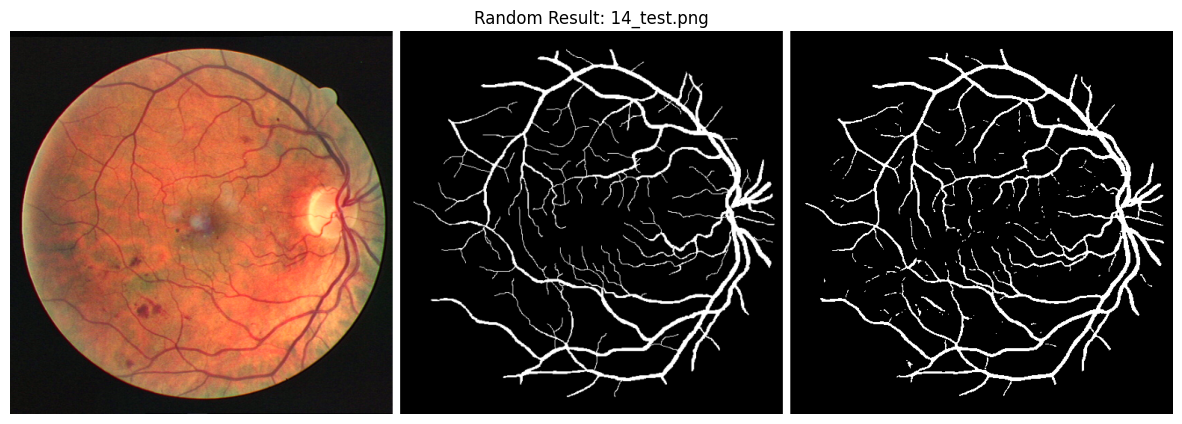

In [ ]:


# Set path to results directory
results_path = "/content/results"

# Get list of all PNG images in the directory
image_files = [f for f in os.listdir(results_path) if f.endswith(".png")]

# Pick a random image
random_image = random.choice(image_files)
image_path = os.path.join(results_path, random_image)

# Read the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

# Display the image
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.title(f"Random Result: {random_image}")
plt.axis('off')
plt.show()

In [ ]:
test_y[0]

'new_data/test/mask/01_test.png'

In [ ]:
import imageio
mask = imageio.mimread(test_y[0])[0]
np.unique(mask)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
!zip -r /content/all_data_attn_2.zip /content/files /content/logs /content/results

  adding: content/files/ (stored 0%)
  adding: content/files/model.keras (deflated 9%)
  adding: content/files/score.csv (deflated 51%)
  adding: content/files/data.csv (deflated 55%)
  adding: content/logs/ (stored 0%)
  adding: content/logs/validation/ (stored 0%)
  adding: content/logs/validation/events.out.tfevents.1748183904.098606adc792.1806.1.v2 (deflated 79%)
  adding: content/logs/train/ (stored 0%)
  adding: content/logs/train/events.out.tfevents.1748183786.098606adc792.1806.0.v2 (deflated 88%)
  adding: content/results/ (stored 0%)
  adding: content/results/13_test.png (deflated 4%)
  adding: content/results/06_test.png (deflated 3%)
  adding: content/results/02_test.png (deflated 3%)
  adding: content/results/09_test.png (deflated 3%)
  adding: content/results/20_test.png (deflated 3%)
  adding: content/results/05_test.png (deflated 3%)
  adding: content/results/10_test.png (deflated 3%)
  adding: content/results/12_test.png (deflated 3%)
  adding: content/results/03_test.p

In [ ]:
from google.colab import files
files.download("/content/all_data_attn_2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>